In [23]:
import OpenBlender
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
import time
import ast

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [87]:
params = open("parameters.txt","r")
params = ast.literal_eval(params.read())
params

{'myToken': '5f9e75d695162929c1b471ebMCKoNAvASdFrlF92mZmSxwH9TN02oX',
 'userID': '5f9e75d695162929c1b471eb'}

In [102]:
myToken = params['myToken']
userID = params['userID']
action = 'API_getObservationsFromDataset'
msft_datasetID = '5d4ca8709516290b01c9d725'

In [27]:
parameters = { 
    'token':myToken,
    'id_user':userID,
    'id_dataset':msft_datasetID,
    'consumption_confirmation':'on' 
}
        

df = pd.read_json(json.dumps(OpenBlender.call(action, parameters)['sample']), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
df.reset_index(drop=True, inplace=True)
df['date'] = [OpenBlender.unixToDate(ts, timezone = 'GMT') for ts in df.timestamp]
df = df.drop('timestamp', axis = 1)

Task ID: '5f9e7c060895fafb4a9d8d4b'.
Total estimated consumption: 11660.86 processing units.
Continue?  [y] yes 	 [n] noy
Task confirmed. Starting download..
14.29 %
28.57 %
42.86 %
57.14 %
71.43 %
85.71 %
100.0 % completed.


In [28]:
df.head()

volume   price    high     low    open  change                 date
0  36.98M  202.47  204.24  199.64  203.49  -1.10%  30-10-2020 17:00:00
1  51.20M  202.68  208.72  202.13  207.65  -4.96%  28-10-2020 17:00:00
2  36.70M  213.25  214.67  210.33  211.65   1.51%  27-10-2020 17:00:00
3  37.11M  210.08  216.30  208.16  213.73  -2.84%  26-10-2020 17:00:00
4  18.88M  216.23  216.23  213.22  215.03   0.62%  23-10-2020 17:00:00

In [35]:
# switch the order of the columns
cols = df.columns.tolist()
newcols = cols[-1:]+cols[:-1]
df = df[newcols]
df.head()

date  volume   price    high     low    open  change
0  30-10-2020 17:00:00  36.98M  202.47  204.24  199.64  203.49  -1.10%
1  28-10-2020 17:00:00  51.20M  202.68  208.72  202.13  207.65  -4.96%
2  27-10-2020 17:00:00  36.70M  213.25  214.67  210.33  211.65   1.51%
3  26-10-2020 17:00:00  37.11M  210.08  216.30  208.16  213.73  -2.84%
4  23-10-2020 17:00:00  18.88M  216.23  216.23  213.22  215.03   0.62%

In [41]:
# range of the date
df.date[0], df.date[len(df)-1]

('30-10-2020 17:00:00', '02-01-2013 16:00:00')

In [48]:
# df by ascending date
df_ascending = df.reindex(index=df.index[::-1])

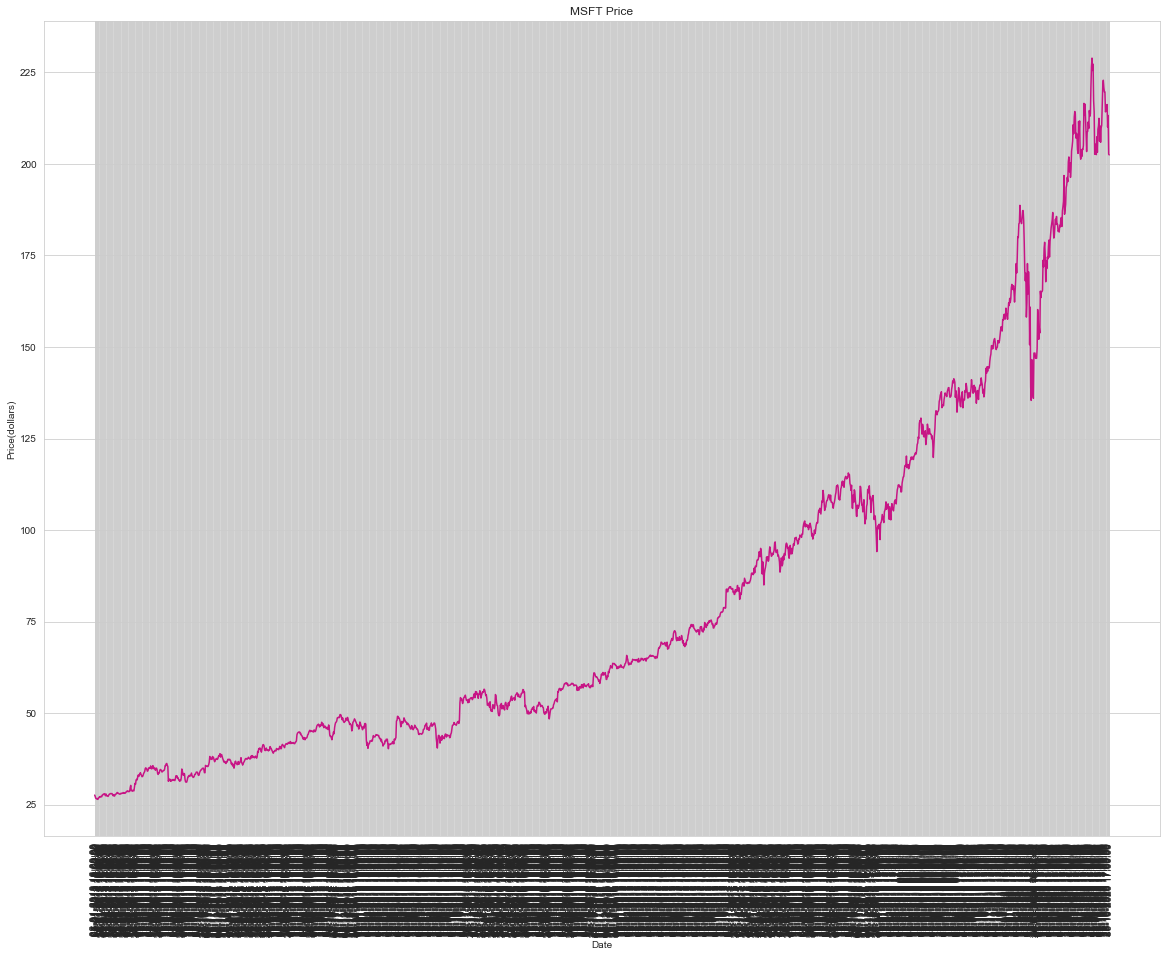

CPU times: user 1min 42s, sys: 10.1 s, total: 1min 52s
Wall time: 1min 54s


In [51]:
%%time
# Create figure and plot space
fig, ax = plt.subplots(figsize=(20, 15))
sns.set_style("whitegrid")

# Add x-axis and y-axis
ax.plot(df_ascending['date'],
        df_ascending['price'],
        color='mediumvioletred')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Price(dollars)",
       title="MSFT Price")

plt.xticks(rotation=90)
plt.show()

In [52]:
# Create a copy of df just in case
df2 = df.copy()

In [53]:
df2['timestamp'] = OpenBlender.dateToUnix(df2['date'], 
                                           date_format = '%d-%m-%Y %H:%M:%S', 
                                           timezone = 'GMT')

In [63]:
# Search on OpenBlender
search_keyword = 'business'
df2 = df2.sort_values('timestamp').reset_index(drop = True)
print('From : ' + OpenBlender.unixToDate(min(df2.timestamp)))
print('Until: ' + OpenBlender.unixToDate(max(df2.timestamp)))

search_results = OpenBlender.searchTimeBlends(myToken,
                             df2.timestamp,
                             search_keyword)

From : 02-01-2013 16:00:00
Until: 30-10-2020 17:00:00


In [71]:
# Sort by the percentage of intersection
sorted(search_results, key = lambda i: float(i['intersection'][:-1]), reverse=True)

[{'name': 'Washington Post Business News Headlines',
  'url': 'https://www.openblender.io/#/dataset/explore/5d571a989516293a12ad4f4c',
  'id_dataset': '5d571a989516293a12ad4f4c',
  'features': ['headline', 'publisher', 'timestamp', 'title', 'url'],
  'num_observations': 788,
  'intersection': '100%',
  'description': 'Washington Post Business News Headlines daily headlines'},
 {'name': 'FoxBusiness Twitter',
  'url': 'https://www.openblender.io/#/dataset/explore/5e13a210951629100dd89e84',
  'id_dataset': '5e13a210951629100dd89e84',
  'features': ['favorites',
   'geo',
   'hashtags',
   'id',
   'mentions',
   'permalink',
   'retweets',
   'text',
   'timestamp',
   'username'],
  'num_observations': 97950,
  'intersection': '100%',
  'description': 'The latest Twitter threads from FoxBusiness (@FoxBusiness)'},
 {'name': 'Belfast Telegraph Business headlines',
  'url': 'https://www.openblender.io/#/dataset/explore/5d884b739516294231c5961e',
  'id_dataset': '5d884b739516294231c5961e',


We decided to go with 'FoxBusiness Twitter'(100% intersection).

In [103]:
positive_filter = {'name' : 'microsoft', 
                   'match_ngrams': ['microsoft', 'stock', 'windows', 
                                    'azure', 'satya nadella', 'bill gates']} #general filter not postive
# We need to pass the 'id_dataset', the name of the
# column (which is 'text') and an optional filter.
blend_source = {
                'id_dataset':'5e13a210951629100dd89e84',
                'feature' : 'text',
                'filter_text' : positive_filter
            }
df_blend = OpenBlender.timeBlend( token = myToken,
                                  anchor_ts = df2.timestamp,
                                  blend_source = blend_source,
                                  blend_type = 'agg_in_intervals',
                                  interval_size = 60 * 60 * 24,#one day
                                  direction = 'time_prior',#prior 24 hours
                                  interval_output = 'list')

------------------------------------------------
API call error: There are not enough processing units to complete this task. Please upgrade your account or buy units in https://www.openblender.io/ at $0.0001 USD/unit.
------------------------------------------------

{"status": "internal error", "msg": "'bool' object is not subscriptable"}


In [ ]:
# negative_filter = {'name' : 'negative', 
#                    'match_ngrams': ['microsoft', 'stock', 'plummet', 
#                                     'negative', 'drop', 'sell', 'fund raising']}

# blend_source_neg = {
#                 'id_dataset':'5e13a210951629100dd89e84',
#                 'feature' : 'text',
#                 'filter_text' : negative_filter
#             }

# df_blend = OpenBlender.timeBlend( token = myToken,
#                                   anchor_ts = df2.timestamp,
#                                   blend_source = blend_source_neg,
#                                   blend_type = 'agg_in_intervals',
#                                   interval_size = 60 * 60 * 24,#one day
#                                   direction = 'time_prior',#prior 24 hours
#                                   interval_output = 'list')
# df2 = pd.concat([df2, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)

In [95]:
df_anchor = pd.concat([df2, df_blend.loc[:, df_blend.columns != 'timestamp']], axis = 1)
df_anchor.head()

date  volume  price   high    low   open  change  \
0  02-01-2013 16:00:00  52.91M  27.62  27.73  27.15  27.25   3.41%   
1  03-01-2013 16:00:00  48.30M  27.25  27.65  27.16  27.63  -1.34%   
2  04-01-2013 16:00:00  52.52M  26.74  27.34  26.73  27.27  -1.87%   
3  07-01-2013 16:00:00  37.12M  26.69  26.88  26.64  26.77  -0.19%   
4  08-01-2013 16:00:00  44.70M  26.55  26.79  26.46  26.75  -0.52%   

      timestamp  FOXBUSINES.text_COUNT_last1days:microsoft  \
0  1.357142e+09                                          0   
1  1.357229e+09                                          2   
2  1.357315e+09                                          2   
3  1.357574e+09                                          1   
4  1.357661e+09                                          0   

                 FOXBUSINES.text_last1days:microsoft  
0                                                 []  
1  [stocks ease after yesterdays big rally econom...  
2  [stocks mildly lower as traders mull mostly in...  
3  [stock futures edge lower after last weeks sur...  
4                                                 []

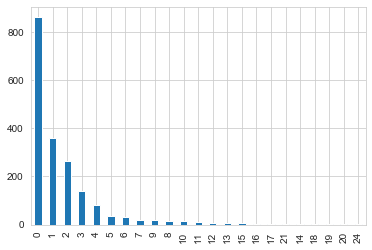

In [127]:
df_anchor['FOXBUSINES.text_COUNT_last1days:microsoft'].value_counts().plot(kind='bar')

In [178]:
#df_anchor.to_csv("df_v1.csv")

In [141]:
# feature engineer the last column
def textTransform(doc):
    output = ''
    if (len(doc) == 0):
        return output
    else:
        for each in doc:
            output += each
        return output  

In [144]:
df_anchor['transformedDoc'] = df_anchor['FOXBUSINES.text_last1days:microsoft'].apply(textTransform)

In [171]:
# initiate the vectorizer object
countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english', ngram_range=(1,2))
tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words= 'english', ngram_range=(1,2))

# convert th documents into a matrix
count_wm = countvectorizer.fit_transform(df_anchor['transformedDoc'])
tfidf_wm = tfidfvectorizer.fit_transform(df_anchor['transformedDoc'])

#count_tokens = tfidfvectorizer.get_feature_names() # no difference
count_tokens = countvectorizer.get_feature_names()
tfidf_tokens = tfidfvectorizer.get_feature_names()